In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from skimage.transform import resize
from tensorflow.keras.optimizers import RMSprop

C:\Users\tiles\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


In [2]:
file_path = r"C:\Users\tiles\Downloads\spectrograms.h5"
with h5py.File(file_path, 'r') as f:
    species_keys = list(f.keys())
    species = species_keys[0]
    spectrograms = f[species][:]

#### EDA

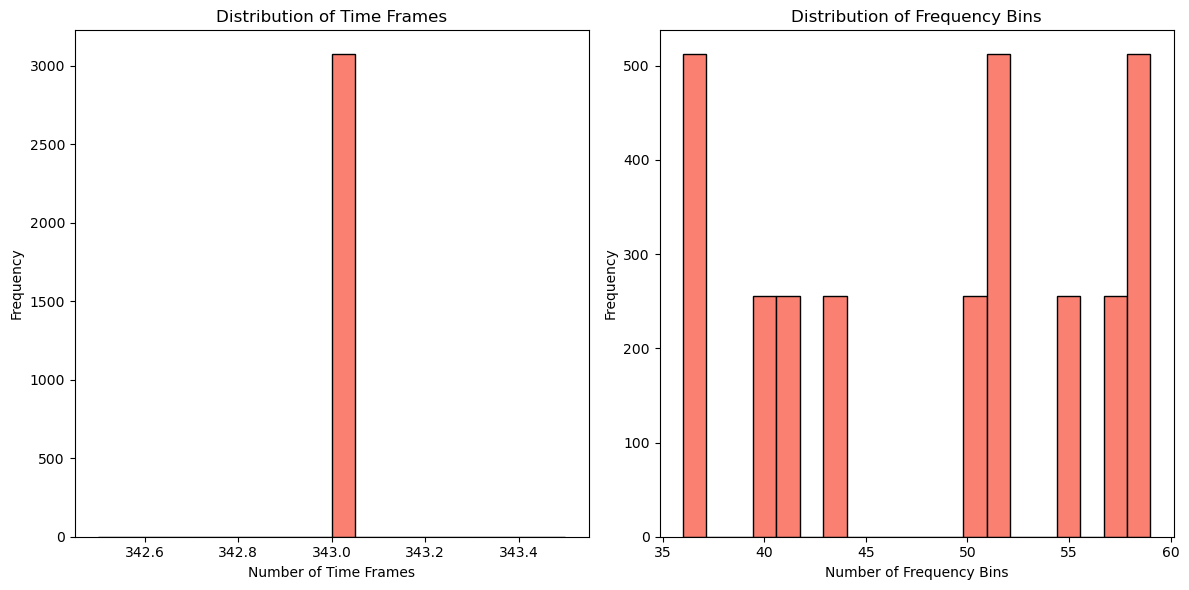

In [3]:
spectrogram_shapes = []

with h5py.File(file_path, 'r') as f:
    species_keys = list(f.keys())
    
    for species in species_keys:
        spectrograms = f[species][:]
        
        for spectrogram in spectrograms:
            spectrogram_shapes.append(spectrogram.shape)

spectrogram_shapes = np.array(spectrogram_shapes)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].hist(spectrogram_shapes[:, 0], bins=20, color='salmon', edgecolor='black')
axes[0].set_title('Distribution of Time Frames')
axes[0].set_xlabel('Number of Time Frames')
axes[0].set_ylabel('Frequency')

axes[1].hist(spectrogram_shapes[:, 1], bins=20, color='salmon', edgecolor='black')
axes[1].set_title('Distribution of Frequency Bins')
axes[1].set_xlabel('Number of Frequency Bins')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

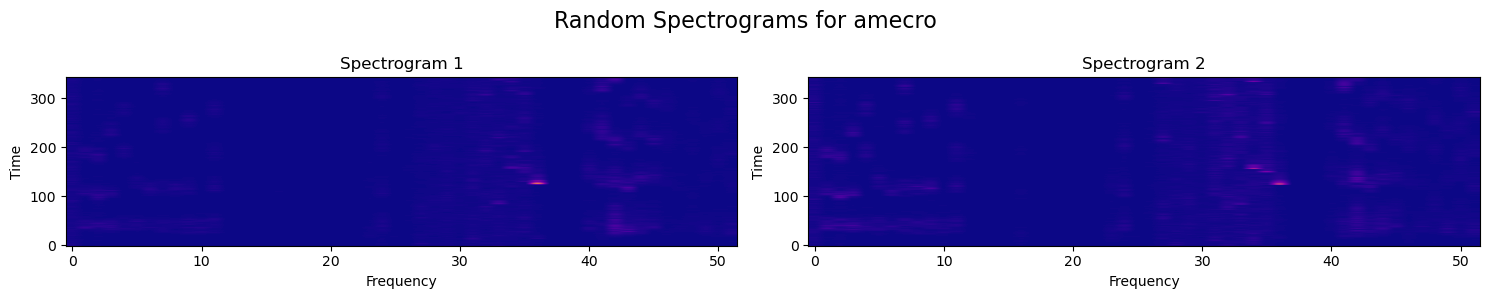

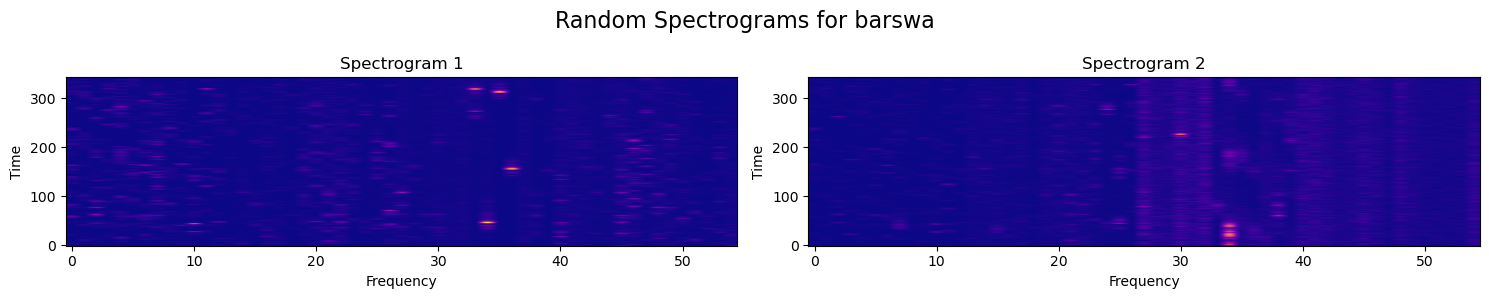

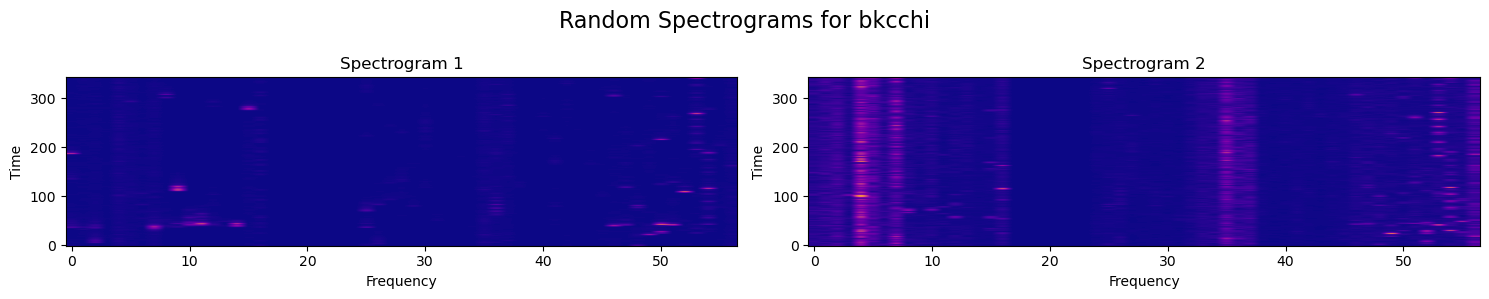

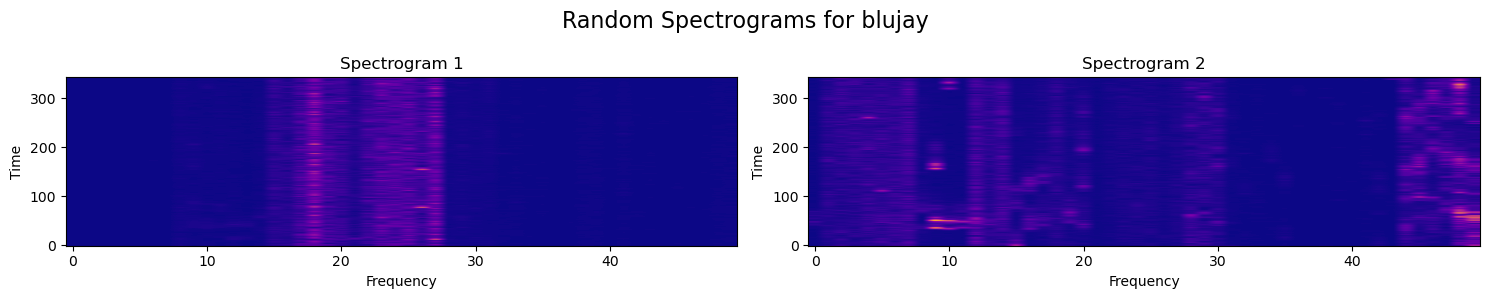

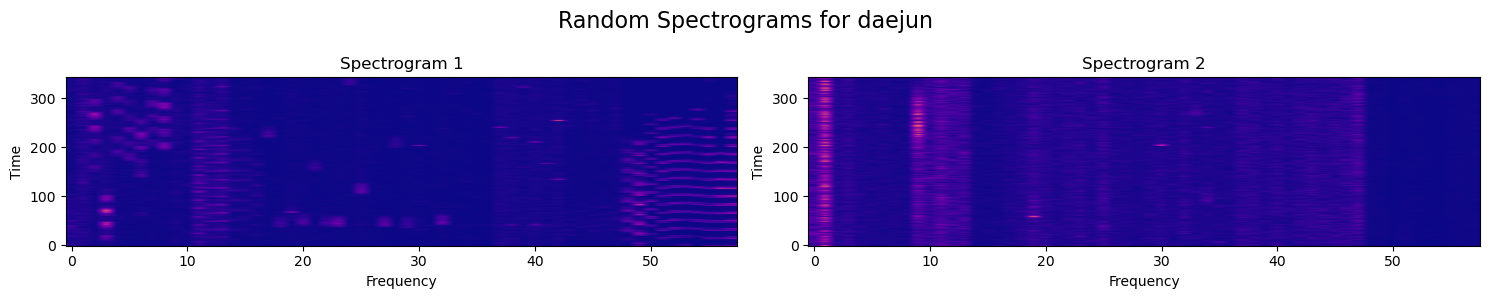

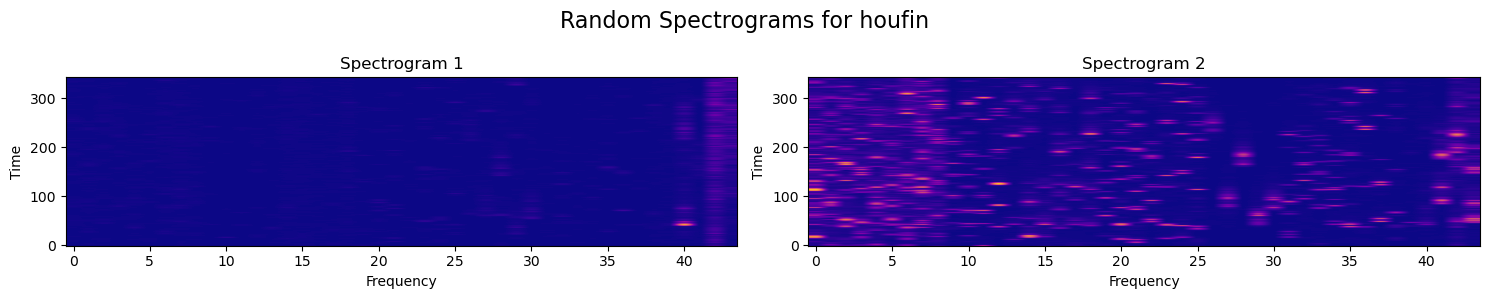

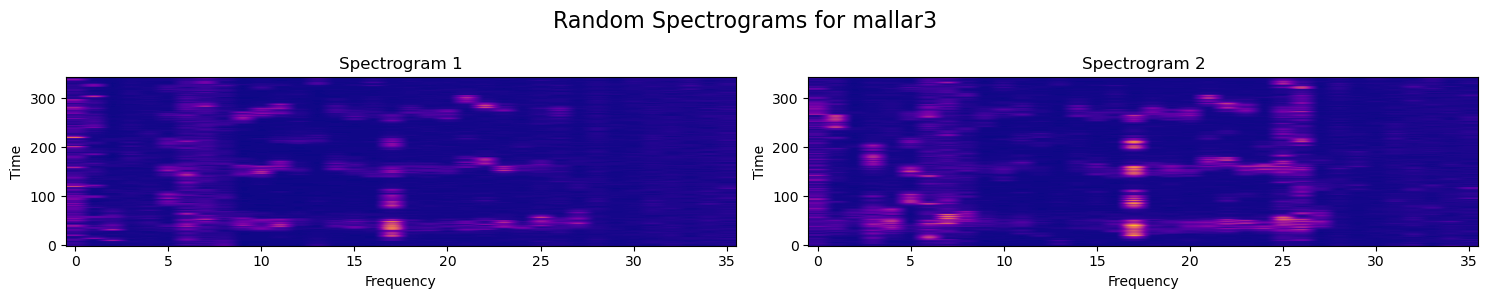

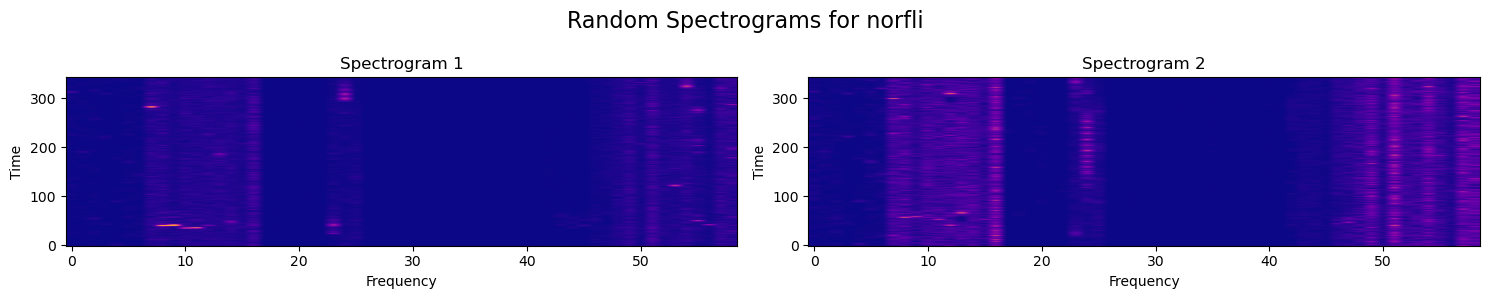

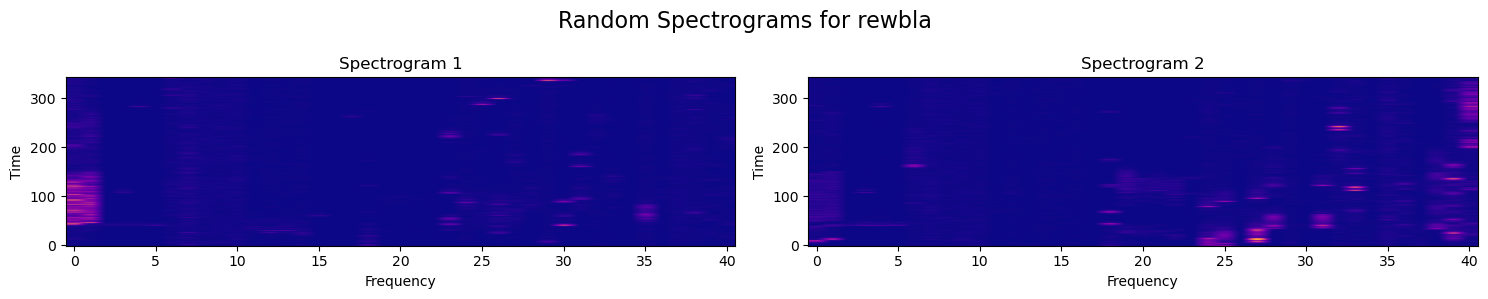

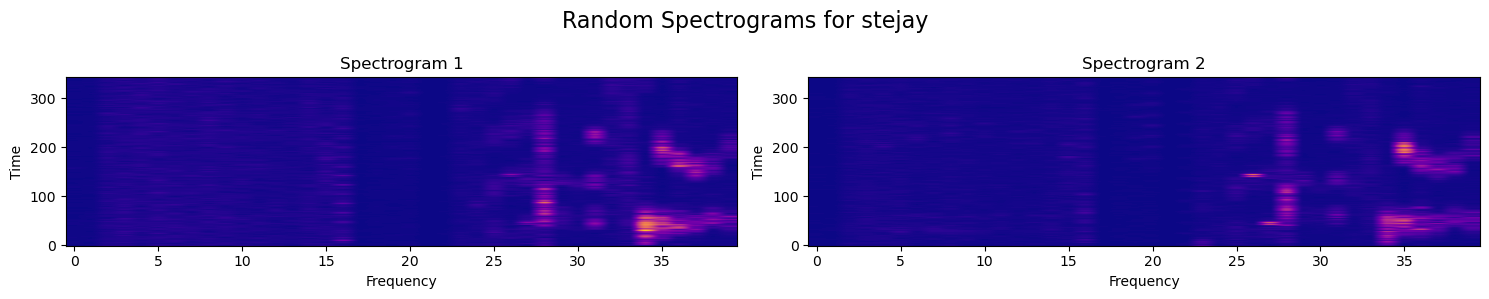

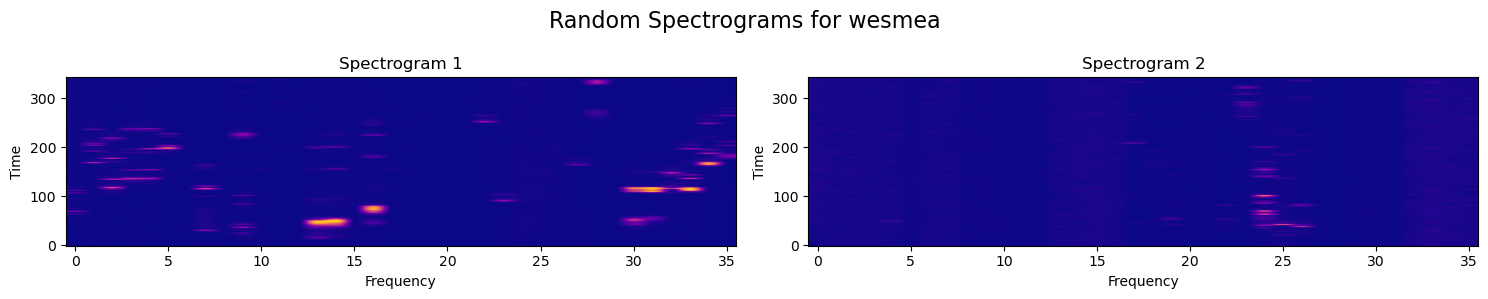

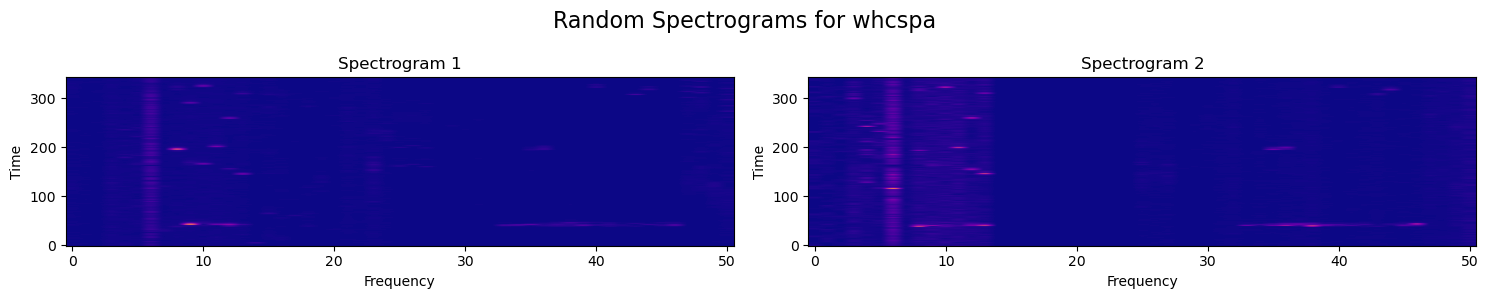

In [4]:
def explore_data():
    with h5py.File(file_path, 'r') as f:
        species_keys = list(f.keys())
        
        num_spectrograms_to_visualize = 2
        
        for species in species_keys:
            spectrograms = f[species][:]
            
            fig, axes = plt.subplots(1, num_spectrograms_to_visualize, figsize=(15, 3))
            fig.suptitle(f"Random Spectrograms for {species}", fontsize=16)
            
            for i in range(num_spectrograms_to_visualize):
                random_index = np.random.randint(0, len(spectrograms))
                axes[i].imshow(spectrograms[random_index], cmap='plasma', origin='lower')
                axes[i].set_title(f"Spectrogram {i+1}")
                axes[i].set_xlabel('Frequency')
                axes[i].set_ylabel('Time')
                axes[i].set_aspect('auto')
        
            plt.tight_layout()
            plt.show()

explore_data()


#### Binary Model

In [131]:
def load_data_binary(species_names):
    X = []
    y = []
    with h5py.File(file_path, 'r') as f:
        species_keys = list(f.keys())
        for i, species_name in enumerate(species_names):
            if species_name in species_keys:
                species_index = species_keys.index(species_name)
                spectrograms = f[species_keys[species_index]][:]
                for spectrogram in spectrograms:
                    resized_spectrogram = resize(spectrogram, (128, 128), anti_aliasing=True)
                    X.append(resized_spectrogram.flatten())
                    y.append(i)
    X = np.array(X)
    y = np.array(y)
    return X, y


species_names = ['bkcchi', 'barswa']

X, y = load_data_binary(species_names)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model_nn = Sequential([
    Dense(256, activation='relu', input_shape=(128*128,)),
    Dropout(0.4),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),  
    Dropout(0.2),                   
    Dense(32, activation='relu'), 
    Dense(1, activation='sigmoid')
])

model_nn.summary()


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_21 (Dense)                │ (None, 256)            │     4,194,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,237,825 (16.17 MB)

 Trainable params: 4,237,825 (16.17 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 299ms/step - accuracy: 0.6465 - loss: 0.6854 - val_accuracy: 0.9815 - val_loss: 0.6284
Epoch 2/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.9235 - loss: 0.6112 - val_accuracy: 0.9907 - val_loss: 0.5064
Epoch 3/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.9604 - loss: 0.4285 - val_accuracy: 0.9907 - val_loss: 0.3788
Epoch 4/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.9921 - loss: 0.2946 - val_accuracy: 0.9907 - val_loss: 0.3496
Epoch 5/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.9947 - loss: 0.2293 - val_accuracy: 0.9907 - val_loss: 0.2882
Epoch 6/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 1.0000 - loss: 0.1315 - val_accuracy: 0.9907 - val_loss: 0.3023
Epoch 7/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.9841 - loss: 0.1847 - val_accuracy: 0.9907 - val_loss: 0.3496
Epoch 8/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.9973 - loss: 0.1232 - val_accuracy: 0.9907 - val_loss: 0.2676

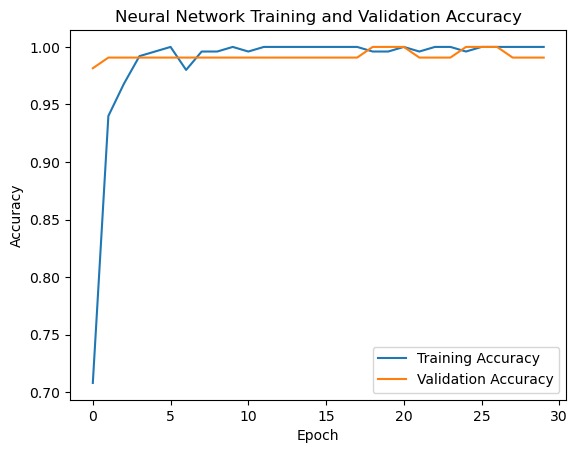

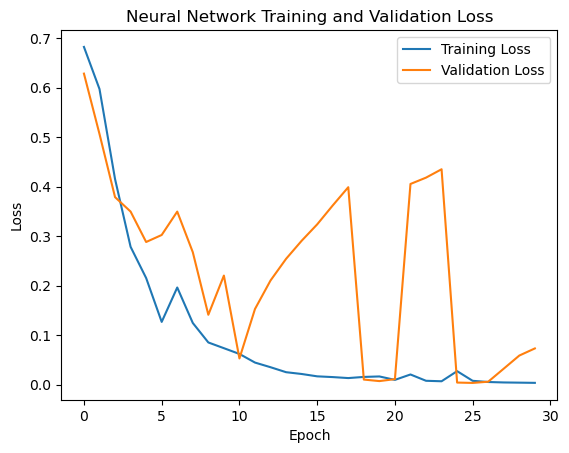

Neural Network Test Accuracy: 99.35%
CPU times: total: 4.27 s
Wall time: 7.45 s


In [6]:
%%time

model_nn.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

history_nn = model_nn.fit(X_train, y_train, epochs=30, batch_size=128, validation_split=0.3)

plt.plot(history_nn.history['accuracy'], label='Training Accuracy')
plt.plot(history_nn.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Neural Network Training and Validation Accuracy')
plt.legend()
plt.show()

plt.plot(history_nn.history['loss'], label='Training Loss')
plt.plot(history_nn.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Neural Network Training and Validation Loss')
plt.legend()
plt.show()

score_nn = model_nn.evaluate(X_test, y_test, verbose=0)
print("Neural Network Test Accuracy: {:.2f}%".format(score_nn[1]*100))


In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

modellr = Sequential([
    Dense(units=1, activation='sigmoid', input_shape=(128*128,))
])

modellr.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 1)              │        16,385 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,385 (64.00 KB)

 Trainable params: 16,385 (64.00 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
from tensorflow.keras.utils import to_categorical
modellr.compile(loss='binary_crossentropy',
                optimizer='rmsprop',
                metrics=['accuracy'])

modellr.fit(X_train, y_train,
            epochs=30,
            batch_size=128,
            validation_split=0.2,
            verbose=0)

score = modellr.evaluate(X_test, y_test, verbose=0)
print("Test Accuracy: {:.2f}%".format(score[1] * 100))

Test Accuracy: 99.35%


#### The model with Binary classification between 'bkcchi' and 'barswa' provides a good accuarcy. We have performed two of the models first is with Neural Network with 99.35% while second model i.e., Linear Regression has an accuracy of 99.35%. 

#### Multiclass Models

In [10]:
file_path_2 = r"C:\Users\tiles\Downloads\spectrograms.h5"

def load_data_multiclass(file_path_2):
    X = []
    y = []
    species_names = []
    with h5py.File(file_path_2, 'r') as f:
        species_keys = list(f.keys())
        for species_name in species_keys:
            species_names.append(species_name)
            spectrograms = f[species_name][:]
            for i, spectrogram in enumerate(spectrograms):
                resized_spectrogram = resize(spectrogram, (128, 128), anti_aliasing=True)
                X.append(resized_spectrogram.flatten())
                y.append(species_keys.index(species_name))  
    X = np.array(X)
    y = np.array(y)
    return X, y, species_names

X_multi, y_multi, species_names_multi = load_data_multiclass(file_path_2)

X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(X_multi, y_multi, test_size=0.3, random_state=42)


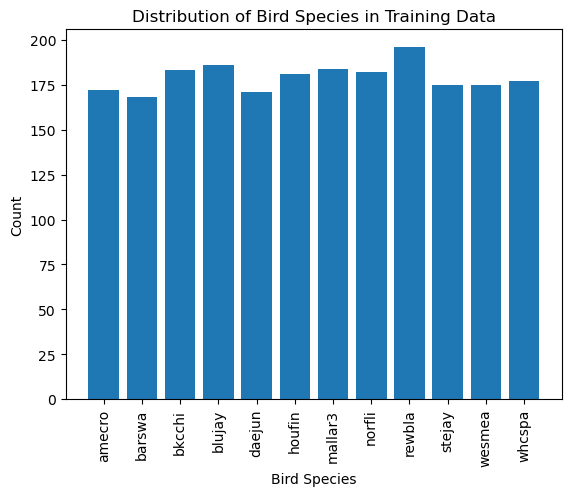

In [11]:
bird_species_counts = np.unique(y_train_multi, return_counts=True)
plt.bar(np.arange(len(bird_species_counts[0])), bird_species_counts[1])
plt.xlabel('Bird Species')
plt.ylabel('Count')
plt.title('Distribution of Bird Species in Training Data')
plt.xticks(np.arange(len(bird_species_counts[0])), [species_names_multi[idx] for idx in bird_species_counts[0]], rotation=90)
plt.show()

In [130]:
multiclass_model = Sequential([
    Dense(256, activation='relu', input_shape=(128*128,)),
    Dropout(0.4),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),  
    Dropout(0.2),                   
    Dense(32, activation='relu'),  
    Dense(len(species_names_multi), activation='softmax') 
])

multiclass_model.summary()

C:\Users\tiles\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_16 (Dense)                │ (None, 256)            │     4,194,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 12)             │           396 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,238,188 (16.17 MB)

 Trainable params: 4,238,188 (16.17 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
%%time

# Compile the model
multiclass_model.compile(loss='sparse_categorical_crossentropy',
                         optimizer='rmsprop',
                         metrics=['accuracy'])

# Train the model
history_multi = multiclass_model.fit(X_train_multi, y_train_multi,
                                     epochs=30,
                                     batch_size=64,
                                     validation_split=0.3)

Epoch 1/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.1972 - loss: 2.3737 - val_accuracy: 0.6000 - val_loss: 1.7810
Epoch 2/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.5418 - loss: 1.7015 - val_accuracy: 0.8682 - val_loss: 1.0786
Epoch 3/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.7526 - loss: 1.1018 - val_accuracy: 0.9566 - val_loss: 0.6776
Epoch 4/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.8982 - loss: 0.7483 - val_accuracy: 0.9876 - val_loss: 0.3878
Epoch 5/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.9358 - loss: 0.5176 - val_accuracy: 0.9907 - val_loss: 0.2044
Epoch 6/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.9537 - loss: 0.3470 - val_accuracy: 0.9938 - val_loss: 0.1391
Epoch 7/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.9724 - loss: 0.2939 - val_accuracy: 0.9969 - val_loss: 0.1052
Epoch 8/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.9711 - loss: 0.2556 - val_accuracy: 0.9953 - v

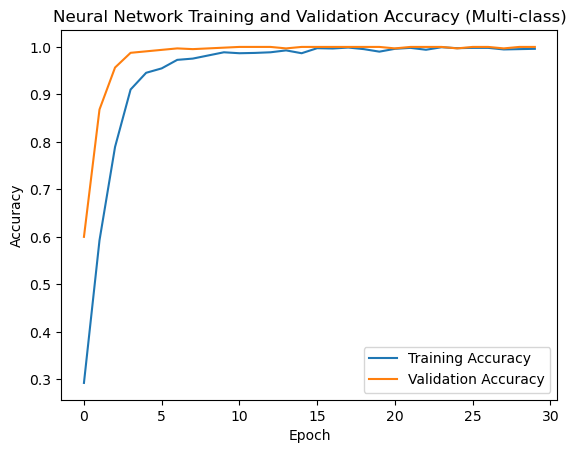

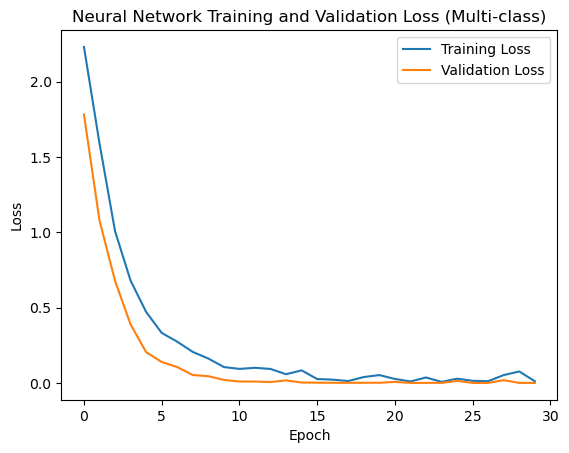

In [16]:
plt.plot(history_multi.history['accuracy'], label='Training Accuracy')
plt.plot(history_multi.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Neural Network Training and Validation Accuracy (Multi-class)')
plt.legend()
plt.show()


plt.plot(history_multi.history['loss'], label='Training Loss')
plt.plot(history_multi.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Neural Network Training and Validation Loss (Multi-class)')
plt.legend()
plt.show()

In [17]:
score_multi = multiclass_model.evaluate(X_test_multi, y_test_multi, verbose=0)
print("Multi-class Model Test Accuracy: {:.2f}%".format(score_multi[1] * 100))

Multi-class Model Test Accuracy: 100.00%


#### In this multiclass model, we have the Neural netwrk model which is performing extremly well with a 100% accuaracy.

#### External Test Data

In [127]:
import librosa
import numpy as np
import os

def create_spectrograms(audio_paths):
    spectrogram_list = []

    for audio_path in audio_paths:
        try:
            print(f"Processing audio file: {audio_path}")
            data, rate = librosa.load(audio_path, sr=22050)

            loud_parts = librosa.effects.split(data, top_db=10)

            for start, end in loud_parts:
                duration = (end - start) / rate

                if duration > 0.5:
                    print(f"Processing bird call")

                    for i in range(start, end, rate):
                        window = data[i:i + 2 * rate]

                        if len(window) == 2 * rate:
                            spec = librosa.feature.melspectrogram(y=window, sr=rate, n_fft=1024, hop_length=512, n_mels=256)

                            if spec.shape[1] < 343:
                                padding = np.zeros((256, 343 - spec.shape[1]))
                                spec = np.hstack((spec, padding))
                            elif spec.shape[1] > 343:
                                spec = spec[:, :343]

                            spec_db = librosa.power_to_db(spec, ref=np.max)
                            spectrogram_list.append(spec_db)

        except Exception as e:
            print(f"Error processing {audio_path}: {e}")

    return spectrogram_list

audio_paths = [
    r"C:\Users\tiles\Downloads\test_birds\test_birds\test1.mp3",
    r"C:\Users\tiles\Downloads\test_birds\test_birds\test2.mp3",
    r"C:\Users\tiles\Downloads\test_birds\test_birds\test3.mp3"
]

spectrograms = create_spectrograms(audio_paths)
if len(spectrograms) > 0:
    print("Number of spectrograms generated:", len(spectrograms))
    print("Shape of the first spectrogram:", spectrograms[0].shape)
else:
    print("No spectrograms generated. Check the preprocessing steps.")

Processing audio file: C:\Users\tiles\Downloads\test_birds\test_birds\test1.mp3
Processing bird call
Processing bird call
Processing audio file: C:\Users\tiles\Downloads\test_birds\test_birds\test2.mp3
Processing bird call
Processing bird call
Processing audio file: C:\Users\tiles\Downloads\test_birds\test_birds\test3.mp3
Processing bird call
Processing bird call
Processing bird call
Processing bird call
Number of spectrograms generated: 12
Shape of the first spectrogram: (256, 343)


In [128]:
import numpy as np

def flatten_spectrograms(spectrogram_list):
    flattened_spectrograms = []
    for spec in spectrogram_list:
        flattened_spec = spec.flatten()
        if len(flattened_spec) < 16384:
            padding = np.zeros(16384 - len(flattened_spec))
            flattened_spec = np.concatenate((flattened_spec, padding))
        elif len(flattened_spec) > 16384:
            flattened_spec = flattened_spec[:16384]
        flattened_spectrograms.append(flattened_spec)

    flattened_spectrograms = np.array(flattened_spectrograms)
    return flattened_spectrograms

spectrograms = create_spectrograms(audio_paths)
flattened_spectrograms = flatten_spectrograms(spectrograms)
print("Shape of the flattened spectrograms:", flattened_spectrograms.shape)

Processing audio file: C:\Users\tiles\Downloads\test_birds\test_birds\test1.mp3
Processing bird call
Processing bird call
Processing audio file: C:\Users\tiles\Downloads\test_birds\test_birds\test2.mp3
Processing bird call
Processing bird call
Processing audio file: C:\Users\tiles\Downloads\test_birds\test_birds\test3.mp3
Processing bird call
Processing bird call
Processing bird call
Processing bird call
Shape of the flattened spectrograms: (12, 16384)


In [129]:
predictions = multiclass_model.predict(flattened_spectrograms)

species_names = []
with h5py.File(file_path, 'r') as f:
    species_keys = list(f.keys())
    for species_name in species_keys:
        species_names.append(species_name)

top_n_predictions = np.argsort(predictions, axis=1)[:, -2:]
top_n_scores = np.sort(predictions, axis=1)[:, -2:]

predicted_species = []
for i in range(3):
    prediction_row = top_n_predictions[i]
    scores_row = top_n_scores[i]
    species_list = [(species_names[idx], scores_row[j]) for j, idx in enumerate(prediction_row)]
    predicted_species.append(species_list)

for i, species_list in enumerate(predicted_species_with_scores):
    print(f"Top 2 Predictions for Test Set {i+1}: {species_list}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Top 2 Predictions for Test Set 1: [('wesmea', 0.0), ('whcspa', 1.0)]
Top 2 Predictions for Test Set 2: [('wesmea', 0.0), ('whcspa', 1.0)]
Top 2 Predictions for Test Set 3: [('wesmea', 0.0), ('whcspa', 1.0)]
